Wyniki metod (posortowane wg liczby iteracji):
newton        x* =   5.379925   |f(x*)| = 5.55e-17   iteracje = 4
siecznych     x* =   5.379925   |f(x*)| = 6.11e-15   iteracje = 9
punkt_staly   x* =   5.379925   |f(x*)| = 2.39e-15   iteracje = 13
bisekcja      x* =   5.379925   |f(x*)| = 4.59e-13   iteracje = 39


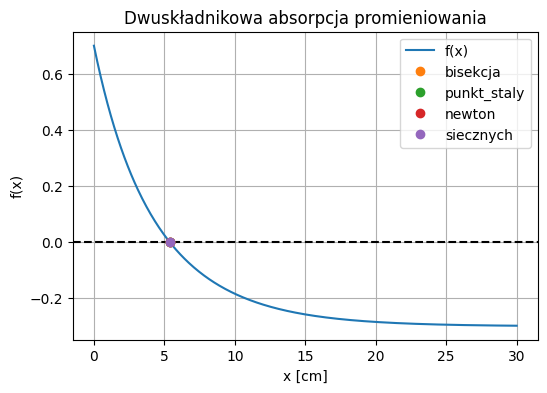

In [3]:
# ---
# Laboratorium: Rozwiązywanie równań nieliniowych
# Model tłumienia promieniowania – dwie składowe
# ---

import math
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# Parametry problemu
# ------------------------
w1, w2 = 0.85, 0.15
mu1, mu2 = 0.20, 0.50   # [1/cm]
I_over_I0 = 0.30        # transmisja (czyli 30%)
a, b = 0.0, 30.0        # przedział
eps = 1e-12
maxit = 10000

# ------------------------
# Funkcja i pochodna
# ------------------------
def f(x):
    return w1*np.exp(-mu1*x) + w2*np.exp(-mu2*x) - I_over_I0

def df(x):
    return -mu1*w1*np.exp(-mu1*x) - mu2*w2*np.exp(-mu2*x)

# ------------------------
# Metody numeryczne
# ------------------------
def bisect(fun, a, b, tol, maxit):
    fa, fb = fun(a), fun(b)
    xs = []
    for k in range(maxit):
        m = 0.5*(a+b)
        fm = fun(m)
        xs.append(m)
        if abs(fm) < tol or 0.5*(b-a) < tol:
            return m, k+1, xs
        if fa*fm <= 0:
            b, fb = m, fm
        else:
            a, fa = m, fm
    return m, maxit, xs

def fixed_point(g, x0, tol, maxit):
    x = x0
    xs = [x]
    for k in range(maxit):
        xn = g(x)
        xs.append(xn)
        if abs(xn - x) < tol:
            return xn, k+1, xs
        x = xn
    return x, maxit, xs

def newton(fun, dfun, x0, tol, maxit):
    x = x0
    xs = [x]
    for k in range(maxit):
        x_new = x - fun(x)/dfun(x)
        xs.append(x_new)
        if abs(x_new - x) < tol or abs(fun(x_new)) < tol:
            return x_new, k+1, xs
        x = x_new
    return x, maxit, xs

def secant(fun, x0, x1, tol, maxit):
    f0, f1 = fun(x0), fun(x1)
    xs = [x0, x1]
    for k in range(2, maxit+1):
        x2 = x1 - f1*(x1 - x0)/(f1 - f0)
        xs.append(x2)
        if abs(x2 - x1) < tol or abs(fun(x2)) < tol:
            return x2, k, xs
        x0, x1 = x1, x2
        f0, f1 = f1, fun(x2)
    return x2, maxit, xs

# ------------------------
# Iteracja punktu stałego
# ------------------------
def g_mu1(x):
    val = (I_over_I0 - w2*np.exp(-mu2*x)) / w1
    return -(1/mu1) * np.log(val)

# ------------------------
# Obliczenia główne
# ------------------------
xb, kb, _ = bisect(f, a, b, eps, maxit)
xfp, kfp, _ = fixed_point(g_mu1, 15.0, eps, maxit)

mu_eff = w1*mu1 + w2*mu2
x0_newton = -np.log(I_over_I0)/mu_eff
xn, kn, _ = newton(f, df, x0_newton, eps, maxit)
xs, ks, _ = secant(f, 0.0, 10.0, eps, maxit)

rows = [
    ("bisekcja", xb, abs(f(xb)), kb),
    ("punkt_staly", xfp, abs(f(xfp)), kfp),
    ("newton", xn, abs(f(xn)), kn),
    ("siecznych", xs, abs(f(xs)), ks),
]

print("Wyniki metod (posortowane wg liczby iteracji):")
for name, xr, fr, it in sorted(rows, key=lambda t: t[3]):
    print(f"{name:12s}  x* = {xr:10.6f}   |f(x*)| = {fr:.2e}   iteracje = {it}")

# ------------------------
# Wykres f(x)
# ------------------------
xs_plot = np.linspace(a, b, 500)
plt.figure(figsize=(6,4))
plt.plot(xs_plot, f(xs_plot), label="f(x)")
plt.axhline(0, color='k', linestyle='--')
for name, xr, _, _ in rows:
    plt.plot(xr, f(xr), 'o', label=name)
plt.xlabel("x [cm]")
plt.ylabel("f(x)")
plt.title("Dwuskładnikowa absorpcja promieniowania")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
from scipy import optimize as spo
import numpy as np

# Metody biblioteczne z licznikiem iteracji: użyjemy root_scalar
res_bis = spo.root_scalar(f, bracket=[a, b], method='bisect', xtol=eps, maxiter=maxit)
res_new = spo.root_scalar(f, x0=x0_newton, fprime=df, method='newton', xtol=eps, maxiter=maxit)
res_sec = spo.root_scalar(f, x0=0.0, x1=10.0, method='secant', xtol=eps, maxiter=maxit)

# Fixed point: scipy.optimize.fixed_point (zwraca wartość, nie liczbę iteracji)
x_fp_lib = spo.fixed_point(lambda x: -(1/mu1)*np.log((I_over_I0 - w2*np.exp(-mu2*x))/w1),
                           x0=15.0, xtol=eps, maxiter=maxit)

# Zbierz porównanie
print("Porównanie z biblioteką (SciPy):\n")

print("Bisekcja vs brentq/bisect (root_scalar):")
print(f"  własna: x* = {xb:.12f}   |f| = {abs(f(xb)):.2e}   iters = {kb}")
print(f"  SciPy : x* = {res_bis.root:.12f}   |f| = {abs(f(res_bis.root)):.2e}   iters = {res_bis.iterations}")
print()

print("Newton vs newton (root_scalar):")
print(f"  własna: x* = {xn:.12f}   |f| = {abs(f(xn)):.2e}   iters = {kn}")
print(f"  SciPy : x* = {res_new.root:.12f}   |f| = {abs(f(res_new.root)):.2e}   iters = {res_new.iterations}")
print()

print("Siecznych vs secant (root_scalar):")
print(f"  własna: x* = {xs:.12f}   |f| = {abs(f(xs)):.2e}   iters = {ks}")
print(f"  SciPy : x* = {res_sec.root:.12f}   |f| = {abs(f(res_sec.root)):.2e}   iters = {res_sec.iterations}")
print()

print("Punkt stały vs fixed_point (SciPy):")
print(f"  własna: x* = {xfp:.12f}   |f| = {abs(f(xfp)):.2e}   iters = {kfp}")
print(f"  SciPy : x* = {x_fp_lib:.12f}   |f| = {abs(f(x_fp_lib)):.2e}   iters = n/d")


Porównanie z biblioteką (SciPy):

Bisekcja vs brentq/bisect (root_scalar):
  własna: x* = 5.379925061698   |f| = 4.59e-13   iters = 39
  SciPy : x* = 5.379925061690   |f| = 2.50e-14   iters = 45

Newton vs newton (root_scalar):
  własna: x* = 5.379925061690   |f| = 5.55e-17   iters = 4
  SciPy : x* = 5.379925061690   |f| = 0.00e+00   iters = 5

Siecznych vs secant (root_scalar):
  własna: x* = 5.379925061690   |f| = 6.11e-15   iters = 9
  SciPy : x* = 5.379925061690   |f| = 5.55e-17   iters = 9

Punkt stały vs fixed_point (SciPy):
  własna: x* = 5.379925061690   |f| = 2.39e-15   iters = 13
  SciPy : x* = 5.379925061690   |f| = 0.00e+00   iters = n/d
